In [ ]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd


from google.colab import drive
drive.mount('/content/drive')

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
import pickle

import seaborn as sns
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')


df = pd.read_excel('/content/drive/MyDrive/output.xlsx')

Mounted at /content/drive


In [ ]:
import sys
sys.version

'3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]'

In [ ]:
df.head()

,Unnamed: 0,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,0,263046056240115712,Do you remember the movie: ‚ÄúEl d√ ≠ a after ...,21226711.0,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,1,262995061304852512,@milenagimon: Look at Sandy in NY! Tremendous ...,192378571.0,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,2,262979898002534400,"Good the photo of Hurricane Sandy, it reminds ...",132303095.0,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,3,262996108400271392,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902.0,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890.0,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


In [ ]:
df

,Unnamed: 0,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,0,263046056240115712,Do you remember the movie: ‚ÄúEl d√ ≠ a after ...,2.122671e+07,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,1,262995061304852512,@milenagimon: Look at Sandy in NY! Tremendous ...,1.923786e+08,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,2,262979898002534400,"Good the photo of Hurricane Sandy, it reminds ...",1.323031e+08,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,3,262996108400271392,Scary shit #hurricane #NY http://t.co/e4JLBUfH,2.419959e+08,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,2.503159e+08,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake
...,...,...,...,...,...,...,...,...
14478,14478,443231991593304128,@BobombDom *slaps TweetDeck with the PigFish h...,2.179311e+09,pigFish_01,Da_Vault_Hunter,Tue Mar 11 03: 48: 36 +0000 2014,fake
14479,14479,443086239127076928,New Species of Fish found in Brazil or just Re...,2.548431e+08,pigFish_01,DjSituation_RC,Mon Mar 10 18: 09: 26 +0000 2014,fake
14480,14480,442978105238753280,What do we call this? #pigFISH http: \/\/t.co\...,2.367553e+09,pigFish_01,Vivo1Vuyo,Mon Mar 10 10: 59: 45 +0000 2014,fake
14481,14481,442753479782989824,Pigfish? And after the shark there is the pork...,6.031202e+08,pigFish_01,CosimoTarta,Sun Mar 09 20: 07: 10 +0000 2014,fake


In [ ]:
df.isna().sum()
print("Train Dataset missing data:\n",df.isnull().sum(),"\n")

#df = df[df['userId'].notna()]

#print("Train Dataset missing data:\n",df.isnull().sum(),"\n")


Train Dataset missing data:
 Unnamed: 0     0
tweetId        0
tweetText      0
userId        15
imageId(s)    15
username      15
timestamp     15
label         15
dtype: int64 



Topics
boston                 546
bringback              131
columbianChemicals     185
elephant                13
livr                     9
malaysia               501
passport                46
pigFish                 14
sandyA                9847
sandyB                2660
sochi                  402
underwater             112
Name: tweetId, dtype: int64
14      1
46      1
13      1
9       1
185     1
402     1
9847    1
501     1
2660    1
131     1
546     1
112     1
Name: tweetId, dtype: int64


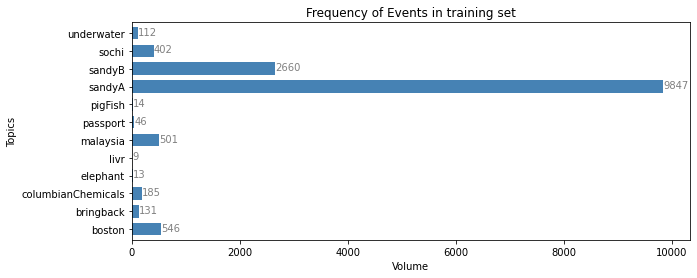

In [ ]:
df.rename(columns = {'imageId(s)':'Topics'}, inplace = True)

imgCount = df.groupby(df.Topics.str.split('_').str[0])['tweetId'].nunique()
print (imgCount)

print(imgCount.value_counts())


fig, ax = plt.subplots()
# plt.rcParams.update({'font.size':30})
plt.title("Frequency of Events in training set")
plt.xlabel('Volume')
plt.ylabel('Events')

imgCount.plot(ax=ax, kind='barh',figsize=[10, 4], color = ['steelblue'], width = 0.7)

for i, v in enumerate(imgCount):
    ax.text(v + 3, i + -0.1, str(v), color='grey')

In [ ]:
print("Train Dataset shape:\n",df.shape,"\n")

Train Dataset shape:
 (14483, 8) 



In [ ]:
print (df.tweetText[11401])

Dear mainstream media... | #sandy #cuba http://t.co/5JPb0Cba


,label
fake,9464
real,5004


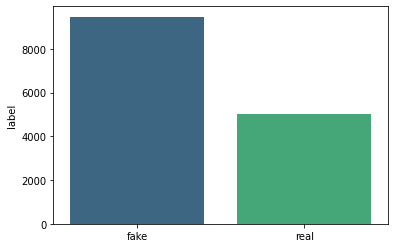

In [ ]:
## using pandas value counts on target will give us number of 0's with is non disaster tweets,
## and 1's which is disaster tweets. 
VCtrain=df['label'].value_counts().to_frame()

## seaborn barplot to display barchart
sns.barplot(data=VCtrain,x=VCtrain.index,y="label",palette="viridis")
VCtrain

,label
fake,9464
real,5004


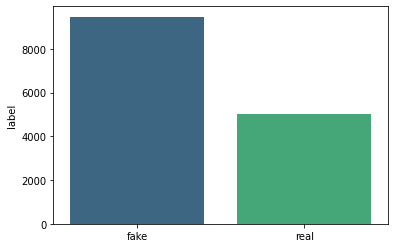

In [ ]:
df["label"].replace({"humor": "fake"}, inplace=True)
## using pandas value counts on target will give us number of 0's with is non disaster tweets,
## and 1's which is disaster tweets. 
VCtrain=df['label'].value_counts().to_frame()

## seaborn barplot to display barchart
sns.barplot(data=VCtrain,x=VCtrain.index,y="label",palette="viridis")
VCtrain

In [ ]:
df['tweetLen'] = df['tweetText'].astype(str).map(len)
print(df['tweetLen'].value_counts())

tweetLengths=df['tweetLen']

under50=[]
over50=[]
over100=[]
over150=[]




for x in tweetLengths:
  if x <= 50:
    under50.append(x)
  elif x > 50 and x <= 100:
    over50.append(x)
  elif x > 100 and x <= 150:
    over100.append(x)
  elif x > 150:
    over150.append(x)



print ("Number of rows < 50:",len(under50))
print ("Number of rows > 50:",len(over50))
print ("Number of rows > 100:",len(over100))
print ("Number of rows > 150:",len(over150))

129    509
128    216
140    209
137    173
36     171
      ... 
322      1
278      1
173      1
248      1
193      1
Name: tweetLen, Length: 213, dtype: int64
Number of rows < 50: 2232
Number of rows > 50: 6324
Number of rows > 100: 5727
Number of rows > 150: 200


In [ ]:

#duplicate

df['tweetText2']= df.tweetText

df.tweetText=df.tweetText.apply(lambda x:x.lower() )
#removing square brackets
df.tweetText=df.tweetText.apply(lambda x:re.sub('\[.*?\]', '', x) )
df.tweetText=df.tweetText.apply(lambda x:re.sub('<.*?>+', '', x) )
#removing hyperlink
df.tweetText=df.tweetText.apply(lambda x:re.sub('https?://\S+|www\.\S+', '', x) )
#removing puncuation
df.tweetText=df.tweetText.apply(lambda x:re.sub('[%s]' % re.escape(string.punctuation), '', x) )
df.tweetText=df.tweetText.apply(lambda x:re.sub('\n' , '', x) )
#remove words containing numbers
df.tweetText=df.tweetText.apply(lambda x:re.sub('\w*\d\w*' , '', x) )

df

,Unnamed: 0,tweetId,tweetText,userId,Topics,username,timestamp,label,tweetLen,tweetText2
0,0,263046056240115712,do you remember the movie ‚äúel d√ ≠ a after t...,2.122671e+07,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake,138,Do you remember the movie: ‚ÄúEl d√ ≠ a after ...
1,1,262995061304852512,milenagimon look at sandy in ny tremendous ima...,1.923786e+08,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake,148,@milenagimon: Look at Sandy in NY! Tremendous ...
2,2,262979898002534400,good the photo of hurricane sandy it reminds m...,1.323031e+08,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake,118,"Good the photo of Hurricane Sandy, it reminds ..."
3,3,262996108400271392,scary shit hurricane ny,2.419959e+08,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake,46,Scary shit #hurricane #NY http://t.co/e4JLBUfH
4,4,263018881839411200,my fave place in the world nyc hurricane sandy...,2.503159e+08,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake,92,My fave place in the world #nyc #hurricane #sa...
...,...,...,...,...,...,...,...,...,...,...
14478,14478,443231991593304128,bobombdom slaps tweetdeck with the pigfish http,2.179311e+09,pigFish_01,Da_Vault_Hunter,Tue Mar 11 03: 48: 36 +0000 2014,fake,71,@BobombDom *slaps TweetDeck with the PigFish h...
14479,14479,443086239127076928,new species of fish found in brazil or just re...,2.548431e+08,pigFish_01,DjSituation_RC,Mon Mar 10 18: 09: 26 +0000 2014,fake,148,New Species of Fish found in Brazil or just Re...
14480,14480,442978105238753280,what do we call this pigfish http,2.367553e+09,pigFish_01,Vivo1Vuyo,Mon Mar 10 10: 59: 45 +0000 2014,fake,57,What do we call this? #pigFISH http: \/\/t.co\...
14481,14481,442753479782989824,pigfish and after the shark there is the pork ...,6.031202e+08,pigFish_01,CosimoTarta,Sun Mar 09 20: 07: 10 +0000 2014,fake,90,Pigfish? And after the shark there is the pork...


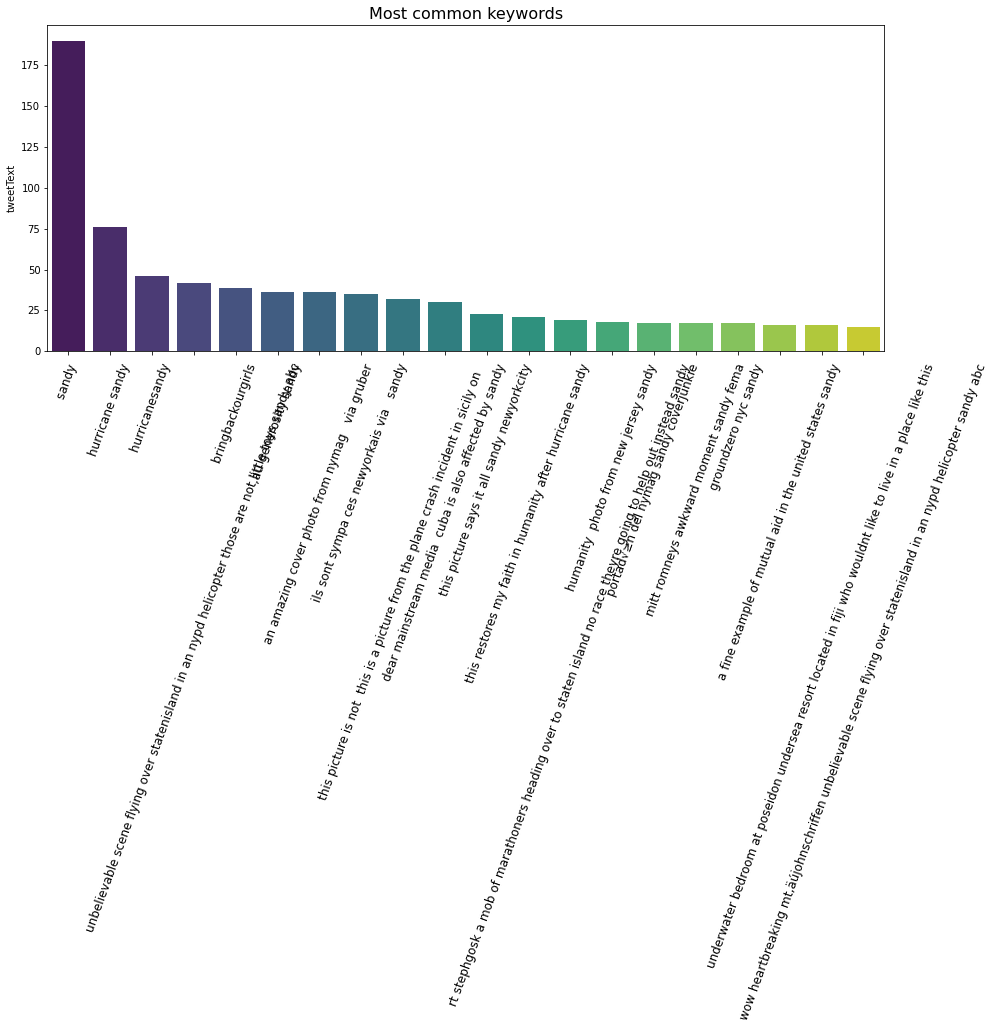

In [ ]:
common_keywords=df["tweetText"].value_counts()[:20].to_frame()
fig=plt.figure(figsize=(15,6))
sns.barplot(data=common_keywords,x=common_keywords.index,y="tweetText",palette="viridis")
plt.title("Most common keywords",size=16)
plt.xticks(rotation=70,size=12);

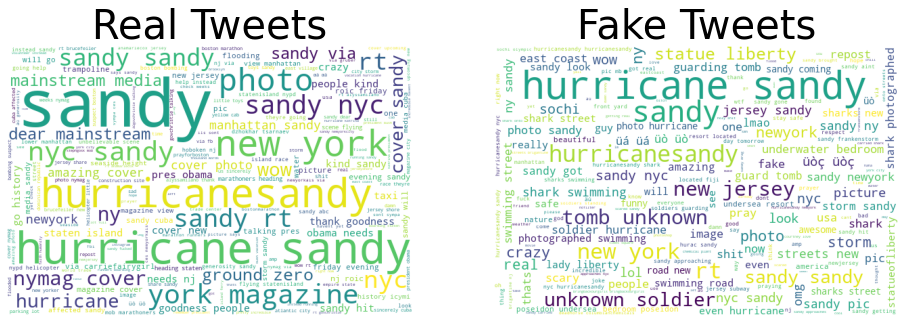

In [ ]:
real_tweets = df[df['label']=='real']['tweetText']
fake_tweets = df[df['label']=='fake']['tweetText']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(real_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Real Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(fake_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Fake Tweets',fontsize=40);



fake    9464
real    5004
Name: label, dtype: int64


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

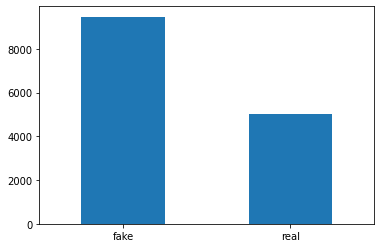

In [ ]:
print(df['label'].value_counts())
fig, ax = plt.subplots()

df['label'].value_counts().plot(ax=ax, kind='bar')

plt.xticks(rotation=0)


In [ ]:
df['tweetLen'] = df['tweetText'].astype(str).map(len)


In [ ]:
print(df['tweetLen'].value_counts())

tweetLengths=df['tweetLen']

6      199
34     180
47     174
97     172
16     171
      ... 
265      1
201      1
169      1
161      1
0        1
Name: tweetLen, Length: 198, dtype: int64


In [ ]:
under50=[]
under100=[]
under150=[]
over150=[]


for x in tweetLengths:
  if x < 50:
    under50.append(x)
  if x >= 50 and x < 100:
    under100.append(x)
  if x >= 100 and x < 150:
    under150.append(x)
  if x >= 150:
    over150.append(x)

print ("Number of rows < 50:",len(under50))
print ("Number of rows < 100  and >= 50:",len(under100))
print ("Number of rows < 150  and >= 100:",len(under150))
print ("Number of rows >= 150 :",len(over150))

Number of rows < 50: 5387
Number of rows < 100  and >= 50: 6694
Number of rows < 150  and >= 100: 2307
Number of rows >= 150 : 95


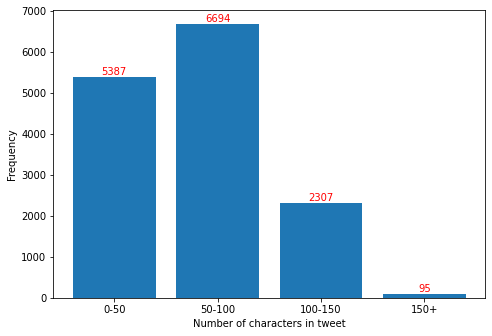

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
XLabels = ['0-50', '50-100', '100-150', '150+']
actual = [len(under50),len(under100),len(under150),len(over150)]
ax.bar(XLabels,actual)
plt.xlabel("Number of characters in tweet")
plt.ylabel("Frequency")

for i in range(len(actual)):
    plt.annotate(str(actual[i]), xy=(XLabels[i],actual[i]), ha='center', va='bottom', color='red')

plt.show()

In [ ]:
#Tokenizer
token=nltk.tokenize.RegexpTokenizer(r'\w+')
#applying token
df['tokens']=df.tweetText.apply(lambda x:token.tokenize(x))
#view
display(df.tokens.head())

0    [do, you, remember, the, movie, äúel, d, a, af...
1    [milenagimon, look, at, sandy, in, ny, tremend...
2    [good, the, photo, of, hurricane, sandy, it, r...
3                         [scary, shit, hurricane, ny]
4    [my, fave, place, in, the, world, nyc, hurrica...
Name: tokens, dtype: object

In [ ]:
print (df.tweetText[7])
print (df.tweetText[4])

crazy pic of hurricane sandy prayers go out to family and friends on the east coast 
my fave place in the world nyc hurricane sandy statueofliberty üóω 


In [ ]:
nltk.download('stopwords')
#removing stop words
df['removedStopwords']=df.tokens.apply(lambda x:[w for w in x if w not in stopwords.words('english')])
#view
df.removedStopwords.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0    [remember, movie, äúel, tomorrow, äù, reminds,...
1    [milenagimon, look, sandy, ny, tremendous, ima...
2    [good, photo, hurricane, sandy, reminds, movie...
3                         [scary, shit, hurricane, ny]
4    [fave, place, world, nyc, hurricane, sandy, st...
Name: removedStopwords, dtype: object

In [ ]:
print (df.tweetText[7])
print (df.tweetText[4])

crazy pic of hurricane sandy prayers go out to family and friends on the east coast 
my fave place in the world nyc hurricane sandy statueofliberty üóω 


In [ ]:
stemmer = nltk.stem.PorterStemmer()
df['Stemmed']=df.tokens.apply(lambda x:" ".join(stemmer.stem(token) for token in x))
#View
df.tweetText.head()

0    do you remember the movie ‚äúel d√ ≠ a after t...
1    milenagimon look at sandy in ny tremendous ima...
2    good the photo of hurricane sandy it reminds m...
3                             scary shit hurricane ny 
4    my fave place in the world nyc hurricane sandy...
Name: tweetText, dtype: object

In [ ]:
print (df.tweetText[0])
print (df.tweetText[4])

do you remember the movie ‚äúel d√ ≠ a after tomorrow ‚äù it reminds me of what is happening with hurricane sandy 
my fave place in the world nyc hurricane sandy statueofliberty üóω 


In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
import nltk
nltk.download('wordnet')

def lemmatizing(words):
    lemmatizer =WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]
df['WordnetLemmed']=df['tokens'].apply(lambda x: lemmatizing(x))

def final_text(words):
     return ' '.join(words)
df['WordnetLemmed']=df['WordnetLemmed'].apply(lambda x:final_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import word_tokenize, pos_tag, pos_tag_sents
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
texts = df['tweetText'].tolist()
map(word_tokenize, texts)
df['tweetText'].apply(word_tokenize)
df['tweetText'].apply(word_tokenize).tolist()
pos_tag_sents( df['tweetText'].apply(word_tokenize).tolist() )
df['POS'] = pos_tag_sents( df['tweetText'].apply(word_tokenize).tolist() )

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
df

,Unnamed: 0,tweetId,tweetText,userId,Topics,username,timestamp,label,tweetLen,tweetText2,tokens,removedStopwords,Stemmed,WordnetLemmed,POS
0,0,263046056240115712,do you remember the movie ‚äúel d√ ≠ a after t...,2.122671e+07,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake,114,Do you remember the movie: ‚ÄúEl d√ ≠ a after ...,"[do, you, remember, the, movie, äúel, d, a, af...","[remember, movie, äúel, tomorrow, äù, reminds,...",do you rememb the movi äúel d a after tomorrow...,do you remember the movie äúel d a after tomor...,"[(do, VB), (you, PRP), (remember, VB), (the, D..."
1,1,262995061304852512,milenagimon look at sandy in ny tremendous ima...,1.923786e+08,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake,119,@milenagimon: Look at Sandy in NY! Tremendous ...,"[milenagimon, look, at, sandy, in, ny, tremend...","[milenagimon, look, sandy, ny, tremendous, ima...",milenagimon look at sandi in ny tremend imag o...,milenagimon look at sandy in ny tremendous ima...,"[(milenagimon, JJ), (look, NN), (at, IN), (san..."
2,2,262979898002534400,good the photo of hurricane sandy it reminds m...,1.323031e+08,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake,92,"Good the photo of Hurricane Sandy, it reminds ...","[good, the, photo, of, hurricane, sandy, it, r...","[good, photo, hurricane, sandy, reminds, movie...",good the photo of hurrican sandi it remind me ...,good the photo of hurricane sandy it reminds m...,"[(good, JJ), (the, DT), (photo, NN), (of, IN),..."
3,3,262996108400271392,scary shit hurricane ny,2.419959e+08,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake,24,Scary shit #hurricane #NY http://t.co/e4JLBUfH,"[scary, shit, hurricane, ny]","[scary, shit, hurricane, ny]",scari shit hurrican ny,scary shit hurricane ny,"[(scary, JJ), (shit, VBD), (hurricane, NN), (n..."
4,4,263018881839411200,my fave place in the world nyc hurricane sandy...,2.503159e+08,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake,68,My fave place in the world #nyc #hurricane #sa...,"[my, fave, place, in, the, world, nyc, hurrica...","[fave, place, world, nyc, hurricane, sandy, st...",my fave place in the world nyc hurrican sandi ...,my fave place in the world nyc hurricane sandy...,"[(my, PRP$), (fave, JJ), (place, NN), (in, IN)..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14478,14478,443231991593304128,bobombdom slaps tweetdeck with the pigfish http,2.179311e+09,pigFish_01,Da_Vault_Hunter,Tue Mar 11 03: 48: 36 +0000 2014,fake,48,@BobombDom *slaps TweetDeck with the PigFish h...,"[bobombdom, slaps, tweetdeck, with, the, pigfi...","[bobombdom, slaps, tweetdeck, pigfish, http]",bobombdom slap tweetdeck with the pigfish http,bobombdom slap tweetdeck with the pigfish http,"[(bobombdom, NN), (slaps, NNS), (tweetdeck, VB..."
14479,14479,443086239127076928,new species of fish found in brazil or just re...,2.548431e+08,pigFish_01,DjSituation_RC,Mon Mar 10 18: 09: 26 +0000 2014,fake,123,New Species of Fish found in Brazil or just Re...,"[new, species, of, fish, found, in, brazil, or...","[new, species, fish, found, brazil, really, go...",new speci of fish found in brazil or just real...,new specie of fish found in brazil or just rea...,"[(new, JJ), (species, NNS), (of, IN), (fish, J..."
14480,14480,442978105238753280,what do we call this pigfish http,2.367553e+09,pigFish_01,Vivo1Vuyo,Mon Mar 10 10: 59: 45 +0000 2014,fake,34,What do we call this? #pigFISH http: \/\/t.co\...,"[what, do, we, call, this, pigfish, http]","[call, pigfish, http]",what do we call thi pigfish http,what do we call this pigfish http,"[(what, WP), (do, VBP), (we, PRP), (call, VB),..."
14481,14481,442753479782989824,pigfish and after the shark there is the pork ...,6.031202e+08,pigFish_01,CosimoTarta,Sun Mar 09 20: 07: 10 +0000 2014,fake,77,Pigfish? And after the shark there is the pork...,"[pigfish, and, after, the, shark, there, is, t...","[pigfish, shark, pork, fish, http, tco, hqzwgh...",pigfish and a

In [ ]:
print (df.tokens[11144])

['stunning', 'sandy', 'photo', 'of', 'a', 'trampoline', 'caught', 'in', 'milford', 'ct', 'power', 'lines', 'via', 'ncourtmcmanus']


In [ ]:
df['symbolCount']=''
df['hashCount']=''
df['atsCount']=''


for j in range (0,14483):
  str1=df.tweetText2[j]
  alphabets = digits = special = hashs = ats =0

  for i in range(len(str1)):

      if((str1[i] >= 'a' and str1[i] <= 'z') or (str1[i] >= 'A' and str1[i] <= 'Z')): 
          alphabets = alphabets + 1 
      elif(str1[i] >= '0' and str1[i] <= '9'):
          digits = digits + 1
      elif(str1[i] == '#'):
          hashs = hashs + 1
      elif(str1[i] == '@'):
          ats = ats + 1
      elif(str1[i] == '?'):
          special = special + 1
  df.symbolCount[j]=special
  df.hashCount[j]=hashs
  df.atsCount[j]=ats



In [ ]:
ff=df.loc[df['label'] == 'fake']

atLengths=ff['symbolCount']

under50=[]
under100=[]
under150=[]
over150=[]

for x in atLengths:
  if x < 2:
    under50.append(x)
  if x >= 2 and x < 4:
    under100.append(x)
  if x >= 4 and x < 5:
    under150.append(x)
  if x >= 5:
    over150.append(x)

print ("Number of rows < 2:",len(under50))
print ("Number of rows < 4  and >= 2:",len(under100))
print ("Number of rows < 5  and >= 4:",len(under150))
print ("Number of rows >= 5 :",len(over150))


Number of rows < 2: 9312
Number of rows < 4  and >= 2: 130
Number of rows < 5  and >= 4: 14
Number of rows >= 5 : 8


In [ ]:
ff=df.loc[df['label'] == 'real']

atLengths=ff['symbolCount']

under50=[]
under100=[]
under150=[]
over150=[]

for x in atLengths:
  if x < 2:
    under50.append(x)
  if x >= 2 and x < 4:
    under100.append(x)
  if x >= 4 and x < 5:
    under150.append(x)
  if x >= 5:
    over150.append(x)

print ("Number of rows < 2:",len(under50))
print ("Number of rows < 4  and >= 2:",len(under100))
print ("Number of rows < 5  and >= 4:",len(under150))
print ("Number of rows >= 5 :",len(over150))

Number of rows < 2: 4983
Number of rows < 4  and >= 2: 12
Number of rows < 5  and >= 4: 3
Number of rows >= 5 : 6


In [ ]:
import nltk
from collections import Counter
x=[]
for i in range(0,14483):

  text=df.tweetText2[i]
  tagged = nltk.pos_tag(text.split())
  x.append((Counter(i[1] for i in tagged).most_common(5)))





In [ ]:
a=df.POS
from itertools import chain

b=list(chain.from_iterable(a))

pos_counts = nltk.FreqDist(tag for (word, tag) in b)
print ("the five most common tags are", pos_counts.most_common(5))

the five most common tags are [('NN', 53627), ('JJ', 18043), ('IN', 16002), ('DT', 11285), ('NNP', 9448)]


In [ ]:
ff=df.loc[df['label'] == 'real']
zz=df.loc[df['label'] == 'fake']

In [ ]:
a=ff.POS
from itertools import chain

b=list(chain.from_iterable(a))

pos_counts = nltk.FreqDist(tag for (word, tag) in b)
print ("the five most common tags are", pos_counts.most_common(5))

common_tags=pos_counts.most_common(5)

print (common_tags)



the five most common tags are [('NN', 20371), ('JJ', 6609), ('IN', 5974), ('DT', 3650), ('NNS', 2990)]
[('NN', 20371), ('JJ', 6609), ('IN', 5974), ('DT', 3650), ('NNS', 2990)]


In [ ]:
print (common_tags[0][0])

NN


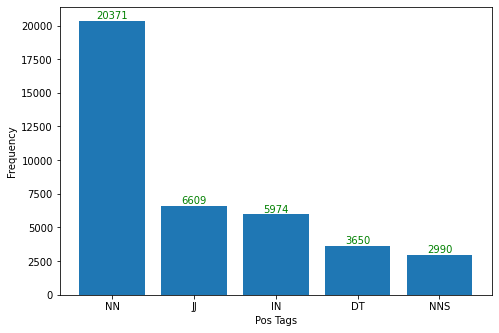

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Labels = []
Freq1 = []

for i in range(0,5):
  Labels.append(common_tags[i][0])

for i in range(0,5):
  Freq1.append(common_tags[i][1])



ax.bar(Labels,Freq1)
plt.xlabel("Pos Tags")
plt.ylabel("Frequency")
plt.style.use('ggplot')

for i in range(len(Freq1)):
    plt.annotate(str(Freq1[i]), xy=(Labels[i],Freq1[i]), ha='center', va='bottom', color='green')

plt.show()

In [ ]:
a= zz.POS
from itertools import chain

b=list(chain.from_iterable(a))

pos_counts = nltk.FreqDist(tag for (word, tag) in b)
print ("the five most common tags are", pos_counts.most_common(5))

the five most common tags are [('NN', 33142), ('JJ', 11396), ('IN', 9995), ('NNP', 7633), ('DT', 7610)]


In [ ]:
print (df.shape)
print (ff.shape)
print (zz.shape)

(14483, 18)
(5004, 18)
(9464, 18)


In [ ]:
count_vectorizer = CountVectorizer()
train_vectors_count = count_vectorizer.fit_transform(df['tweetText'])

In [ ]:
print(train_vectors_count.toarray())
X_df =pd.DataFrame(train_vectors_count.toarray())
X_df

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12198,12199,12200,12201,12202,12203,12204,12205,12206,12207,12208,12209,12210,12211,12212,12213,12214,12215,12216,12217,12218,12219,12220,12221,12222,12223,12224,12225,12226,12227,12228,12229,12230,12231,12232,12233,12234,12235,12236,12237
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14478,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14479,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14480,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from keras.preprocessing.text import Tokenizer

text = df['tweetText'].tolist()
# using tokenizer 
model = Tokenizer()
model.fit_on_texts(text)
 
#print keys 
print(f'Key : {list(model.word_index.keys())}')
 
#create bag of words representation 
rep = model.texts_to_matrix(text, mode='count')
# print(rep)
rep.shape

print (rep)

Key : ['sandy', 'the', 'of', 'hurricane', 'in', 'is', 'this', 'a', 'new', 'hurricanesandy', 'rt', 'nyc', 'to', '‡', 'photo', 'from', 'york', 'on', 'and', 'for', 'jersey', 'i', 'at', 'shark', 'ny', 'are', 'that', 'you', 'newyork', 'via', 'by', 'tomb', 'my', 'cover', 'it', 'picture', 'liberty', 'not', 'out', 'unknown', 'amazing', 'sharks', 'storm', 'was', 'real', 'after', 'nj', 'wow', '∏', 'be', 'pic', 'with', 'during', 'sochi', 'streets', 'soldier', 'like', 'statue', 'crazy', 'found', 'has', 'no', '–', 'what', 'so', 'manhattan', 'about', 'all', 'over', 'swimming', 'nymag', 'they', 'boston', 'even', '±', 'just', 'its', 'an', 'people', 'suspect', 'cuba', 'but', 'soldiers', 'now', 'shit', 'got', 'city', '°', 'have', '≠', 'image', 'up', 'when', 'n', 'if', 'we', 'east', 'me', 'will', 'who', 'there', 'magazine', 'looks', 'safe', 'still', 'lol', 'one', 'usa', 'æ', 'as', 'go', 'statueofliberty', 'down', 'everyone', 'good', 'these', 'fake', 'columbianchemicals', '∞', 'how', 'media', 'flooded', '

In [ ]:
## Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
text = df['tweetText']
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(sorted(vectorizer.vocabulary_))


# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

['aa', 'aaaayo', 'aah', 'aai', 'aan', 'aandhi', 'aaravinjr', 'aaronmnz', 'aaronsimpson', 'aayi', 'abandoned', 'abandoning', 'abc', 'abcnews', 'abd', 'abgpattyo', 'able', 'ablondies', 'abo', 'about', 'abov', 'above', 'abozidw', 'abroad', 'absolute', 'absolutely', 'absurd', 'abt', 'ac', 'acab', 'acaballoregalao', 'academy', 'accepted', 'accepts', 'access', 'accionplaneta', 'accommodation', 'accommodations', 'accomodations', 'according', 'account', 'accuracy', 'accurate', 'accused', 'acercandose', 'achieved', 'achmed', 'acid', 'acknowledged', 'acn', 'acojonaica', 'acpress', 'across', 'act', 'acting', 'action', 'actiongt', 'activated', 'active', 'actively', 'activity', 'actordanwilson', 'actorjiiva', 'actorsiddharth', 'acts', 'actual', 'actualidadrt', 'actually', 'actualshot', 'acuarianojm', 'ad', 'ada', 'adamcarolla', 'adamfclayton', 'adamgilman', 'add', 'addicted', 'addressing', 'adelamusic', 'adelbibi', 'admiren', 'admit', 'adorable', 'adrianbono', 'adrianco', 'adriemcsykergk', 'advance

In [ ]:
## TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# list of text documents
text = df['tweetText']
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(sorted(vectorizer.vocabulary_))
# encode document
vector = vectorizer.transform([text[0]])

print(vectorizer.idf_)

['aa', 'aaaayo', 'aah', 'aai', 'aan', 'aandhi', 'aaravinjr', 'aaronmnz', 'aaronsimpson', 'aayi', 'abandoned', 'abandoning', 'abc', 'abcnews', 'abd', 'abgpattyo', 'able', 'ablondies', 'abo', 'about', 'abov', 'above', 'abozidw', 'abroad', 'absolute', 'absolutely', 'absurd', 'abt', 'ac', 'acab', 'acaballoregalao', 'academy', 'accepted', 'accepts', 'access', 'accionplaneta', 'accommodation', 'accommodations', 'accomodations', 'according', 'account', 'accuracy', 'accurate', 'accused', 'acercandose', 'achieved', 'achmed', 'acid', 'acknowledged', 'acn', 'acojonaica', 'acpress', 'across', 'act', 'acting', 'action', 'actiongt', 'activated', 'active', 'actively', 'activity', 'actordanwilson', 'actorjiiva', 'actorsiddharth', 'acts', 'actual', 'actualidadrt', 'actually', 'actualshot', 'acuarianojm', 'ad', 'ada', 'adamcarolla', 'adamfclayton', 'adamgilman', 'add', 'addicted', 'addressing', 'adelamusic', 'adelbibi', 'admiren', 'admit', 'adorable', 'adrianbono', 'adrianco', 'adriemcsykergk', 'advance

In [ ]:
vector.shape

(1, 12238)

In [ ]:
from gensim.models import Word2Vec
t = df['tokens'].tolist()

import warnings 
warnings.filterwarnings('ignore')
model = Word2Vec(t,min_count=1)


In [ ]:
print (model)

Word2Vec(vocab=12299, size=100, alpha=0.025)


In [ ]:
import spacy
from spacy import displacy

NER = spacy.load("en_core_web_sm")

df['NER']=''
df['NERTag']=''
for i in range (0,14483):
  text1= NER(df.tweetText[i])
  x=[]
  y=[]
  for word in text1.ents:
      x.append([word.text,word.label_])
      y.append([word.label_])
  df.NER[i]=x
  df.NERTag[i]=y

In [ ]:
print (df.NERTag)

0                     [[DATE]]
1        [[PERSON], [PRODUCT]]
2                           []
3                           []
4                      [[ORG]]
                 ...          
14478       [[PERSON], [NORP]]
14479                  [[GPE]]
14480                       []
14481          [[NORP], [ORG]]
14482                       []
Name: NERTag, Length: 14483, dtype: object


In [ ]:
for i in range(0,14483):
  print (df.NER[i])

Streaming output truncated to the last 5000 lines.
[['sandy nyc', 'PERSON']]
[]
[['ohhhh snap', 'ORG'], ['lol hurricane', 'PERSON']]
[]
[['cabs', 'ORG'], ['sandy nyc', 'PERSON']]
[['atlantic city', 'GPE']]
[['atlantic city', 'GPE']]
[['atlantic city', 'GPE'], ['atlantic city', 'GPE']]
[['east village', 'GPE']]
[]
[['hms bounty', 'PERSON'], ['today', 'DATE']]
[['hms bounty', 'PERSON'], ['today', 'DATE']]
[['nyu medical center', 'ORG'], ['sandy nyu nyc', 'PERSON']]
[]
[['ÿßÿñÿåÿäÿ∂ÿßÿü', 'ORG'], ['ÿßÿ≠ÿøÿâ ÿ¥ÿàÿßÿ±ÿπ ÿüÿäÿàÿäÿàÿ±ÿé', 'ORG']]
[['sandy nyc', 'PERSON']]
[]
[['new york city', 'GPE']]
[['™ ÿßÿñÿöÿäÿßÿá ÿ®', 'FAC'], ['ÿßÿπÿµÿßÿ±', 'PRODUCT']]
[['nyc', 'ORG']]
[]
[['al rededor de new york', 'ORG']]
[['bohemia ny', 'ORG']]
[['nyc cabs', 'PERSON']]
[['iamjustshaka', 'GPE']]
[]
[]
[['sandy repost', 'PERSON']]
[]
[['the world trade center', 'ORG'], ['nyc', 'ORG']]
[['instagram', 'CARDINAL']]
[['east village', 'GPE']]
[]
[['jesseandgregs', 'PERSON']]
[]
[]
[]
[['yikes pic', 'PERSON'

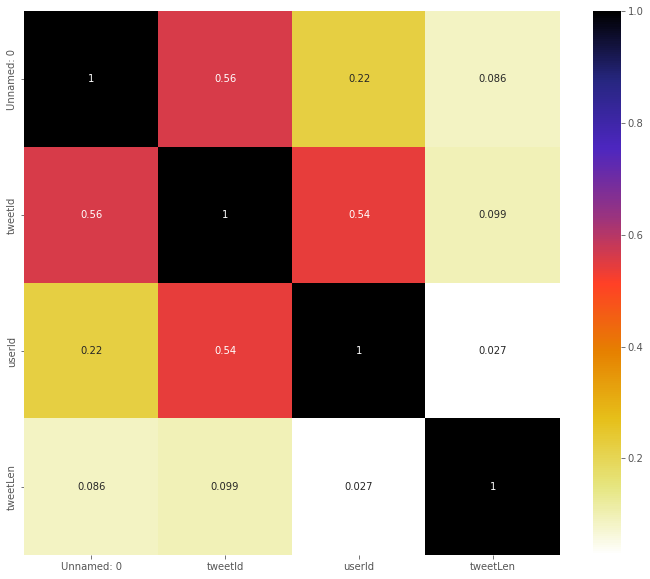

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,10))
cor=df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)

In [ ]:
df

,Unnamed: 0,tweetId,tweetText,userId,Topics,username,timestamp,label,tweetLen,tweetText2,tokens,removedStopwords,Stemmed,WordnetLemmed,POS,symbolCount,hashCount,atsCount,NER,NERTag
0,0,263046056240115712,do you remember the movie ‚äúel d√ ≠ a after t...,2.122671e+07,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake,114,Do you remember the movie: ‚ÄúEl d√ ≠ a after ...,"[do, you, remember, the, movie, äúel, d, a, af...","[remember, movie, äúel, tomorrow, äù, reminds,...",do you rememb the movi äúel d a after tomorrow...,do you remember the movie äúel d a after tomor...,"[(do, VB), (you, PRP), (remember, VB), (the, D...",1,1,0,"[[tomorrow, DATE]]",[[DATE]]
1,1,262995061304852512,milenagimon look at sandy in ny tremendous ima...,1.923786e+08,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake,119,@milenagimon: Look at Sandy in NY! Tremendous ...,"[milenagimon, look, at, sandy, in, ny, tremend...","[milenagimon, look, sandy, ny, tremendous, ima...",milenagimon look at sandi in ny tremend imag o...,milenagimon look at sandy in ny tremendous ima...,"[(milenagimon, JJ), (look, NN), (at, IN), (san...",0,0,1,"[[milenagimon, PERSON], [the d√, PRODUCT]]","[[PERSON], [PRODUCT]]"
2,2,262979898002534400,good the photo of hurricane sandy it reminds m...,1.323031e+08,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake,92,"Good the photo of Hurricane Sandy, it reminds ...","[good, the, photo, of, hurricane, sandy, it, r...","[good, photo, hurricane, sandy, reminds, movie...",good the photo of hurrican sandi it remind me ...,good the photo of hurricane sandy it reminds m...,"[(good, JJ), (the, DT), (photo, NN), (of, IN),...",0,2,0,[],[]
3,3,262996108400271392,scary shit hurricane ny,2.419959e+08,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake,24,Scary shit #hurricane #NY http://t.co/e4JLBUfH,"[scary, shit, hurricane, ny]","[scary, shit, hurricane, ny]",scari shit hurrican ny,scary shit hurricane ny,"[(scary, JJ), (shit, VBD), (hurricane, NN), (n...",0,2,0,[],[]
4,4,263018881839411200,my fave place in the world nyc hurricane sandy...,2.503159e+08,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake,68,My fave place in the world #nyc #hurricane #sa...,"[my, fave, place, in, the, world, nyc, hurrica...","[fave, place, world, nyc, hurricane, sandy, st...",my fave place in the world nyc hurrican sandi ...,my fave place in the world nyc hurricane sandy...,"[(my, PRP$), (fave, JJ), (place, NN), (in, IN)...",0,4,0,"[[üóω, ORG]]",[[ORG]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14478,14478,443231991593304128,bobombdom slaps tweetdeck with the pigfish http,2.179311e+09,pigFish_01,Da_Vault_Hunter,Tue Mar 11 03: 48: 36 +0000 2014,fake,48,@BobombDom *slaps TweetDeck with the PigFish h...,"[bobombdom, slaps, tweetdeck, with, the, pigfi...","[bobombdom, slaps, tweetdeck, pigfish, http]",bobombdom slap tweetdeck with the pigfish http,bobombdom slap tweetdeck with the pigfish http,"[(bobombdom, NN), (slaps, NNS), (tweetdeck, VB...",0,0,1,"[[bobombdom slaps tweetdeck, PERSON], [pigfish...","[[PERSON], [NORP]]"
14479,14479,443086239127076928,new species of fish found in brazil or just re...,2.548431e+08,pigFish_01,DjSituation_RC,Mon Mar 10 18: 09: 26 +0000 2014,fake,123,New Species of Fish found in Brazil or just Re...,"[new, species, of, fish, found, in, brazil, or...","[new, species, fish, found, brazil, really, go...",new speci of fish found in brazil or just real...,new specie of fish found in brazil or just rea...,"[(new, JJ), (species, NNS), (of, IN), (fish, J...",4,0,0,"[[brazil, GPE]]",[[GPE]]
14480,14480,442978105238753280,what do we call this pigfish http,2.367553e+09,pigFish_01,Vivo1Vuyo,Mon Mar 10 10: 59: 45 +0000 2014,fake,34,What do we call this? #pigFISH http: \/\/t.co\...,"[what, do, we, call, this, pigfish, http]","[call, pigfish, http]",what do we call thi pigfish http,what do we call this pigfish http,"[(what, WP), (do, VBP), (we, PRP), (ca

In [ ]:
a=df.NER
from itertools import chain

b=list(chain.from_iterable(a))

pos_counts = nltk.FreqDist(tag for (word, tag) in b)
print ("the five most common tags are", pos_counts.most_common(5))

common_tags=pos_counts.most_common(5)

print (common_tags)


the five most common tags are [('PERSON', 3778), ('GPE', 3437), ('ORG', 2218), ('DATE', 679), ('NORP', 400)]
[('PERSON', 3778), ('GPE', 3437), ('ORG', 2218), ('DATE', 679), ('NORP', 400)]


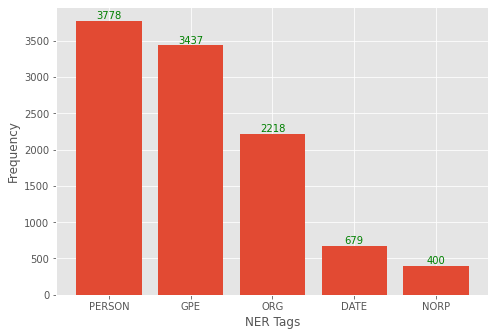

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Labels = []
Freq1 = []

for i in range(0,5):
  Labels.append(common_tags[i][0])

for i in range(0,5):
  Freq1.append(common_tags[i][1])



ax.bar(Labels,Freq1)
plt.xlabel("NER Tags")
plt.ylabel("Frequency")
plt.style.use('ggplot')
plt.palette="viridis"
for i in range(len(Freq1)):
    plt.annotate(str(Freq1[i]), xy=(Labels[i],Freq1[i]), ha='center', va='bottom', color='green',)

plt.show()